In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [15]:
tavg_1hr_ctm = xr.open_dataset("data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0030.V01.nc4")
inst_1hr_ctm = xr.open_dataset("data/GEOS.fp.asm.inst_1hr_ctm_c0720_v72.20210401_0300.V01.nc4")
tavg3_3d_asm = xr.open_dataset("data/GEOS.fp.asm.tavg3_3d_asm_Nv.20210401_0130.V01.nc4")

In [16]:
c720_grid = xr.open_mfdataset([f"data/c720.tile{n}.nc" for n in range(1,7)], concat_dim='nf', combine='nested')

In [17]:
mfxc = tavg_1hr_ctm.MFXC.isel(nf=0).values
mfyc = tavg_1hr_ctm.MFYC.isel(nf=0).values
delp = tavg_1hr_ctm.DELP.isel(nf=0).values

In [18]:
dphi = np.diff(c720_grid.lats.isel(nf=0)[0::2,1::2].values, axis=0)
lam_edges = c720_grid.lons.isel(nf=0)[1::2,0::2].values
lam_edges[lam_edges > 180] -= 360
dlam = np.diff(lam_edges, axis=1)
cosphi=np.cos(np.deg2rad(c720_grid.lats.isel(nf=0)[1::2,0:-1:2].values))  # last slice should be 0:-1:2 or 2::2, depending on if C-grid data includes the first or last coordinate in the supergrid

In [19]:
a = 6371000.7900 # WGS-84 ellipsoid, Radius of Sphere of Equal Volume (R3)

In [20]:
uc = mfxc/(delp*a*dphi)
vc = mfyc/(delp*a*cosphi*dlam)
mag_ucvc = np.sqrt(uc*uc + vc*vc)

In [21]:
print(uc.shape, uc[0,-1,:,:].mean())
print(vc.shape, vc[0,-1,:,:].mean())
print(mag_ucvc.shape, mag_ucvc[0,-1,:,:].mean())

(1, 72, 720, 720) -11.988404999775726
(1, 72, 720, 720) -7.0465164321167695
(1, 72, 720, 720) 48.06572409895641


In [9]:
ua = tavg3_3d_asm.U.values
va = tavg3_3d_asm.V.values
mag_uava = np.sqrt(ua*ua + va*va)

In [10]:
print(ua.shape, ua[0,-1,:,:].mean())
print(va.shape, va[0,-1,:,:].mean())
print(mag_uava.shape, mag_uava[0,-1,:,:].mean())
print(mag_uava.shape, mag_uava[0,-1,200:525,400:690].mean())

(1, 72, 721, 1152) -0.023573332
(1, 72, 721, 1152) 0.24922398
(1, 72, 721, 1152) 7.4788513


5.9875393


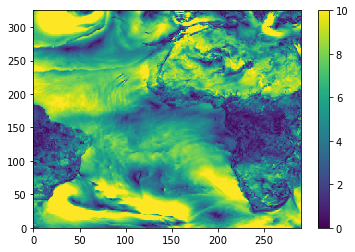

In [23]:
plt.pcolormesh(mag_uava[0,-1,200:525,400:690], norm=plt.Normalize(0, 10))
plt.colorbar()
print(mag_uava[0,-1,200:525,400:690].mean())

6.008215512369551


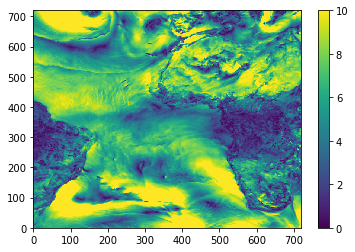

In [22]:
fudge_factor = 8  # <-- 7.5 minute time step? Confirmed by Rob.
plt.pcolormesh(mag_ucvc[0,-1,:,:]/fudge_factor, norm=plt.Normalize(0, 10))
plt.colorbar()
print((mag_ucvc[0,-1,:,:]/8).mean())

In [18]:
import cube_sphere

print(f"Shape of uc: {uc.shape}")

Shape of uc: (1, 72, 720, 720)


In [19]:
vfunc = np.vectorize(cube_sphere.unstagger_cubic_interp, signature='(i)->(j)')

In [28]:
u_dim = -1
v_dim = -2

ua_result = np.apply_along_axis(cube_sphere.unstagger_cubic_interp, u_dim, uc)
ua_result_pad = np.array([(0, 0)]*len(ua_result.shape))
ua_result_pad[u_dim] = (0, 1)
ua_result = np.pad(ua_result, ua_result_pad, 'constant', constant_values=np.nan)

va_result = np.apply_along_axis(cube_sphere.unstagger_cubic_interp, v_dim, vc)
va_result_pad = np.array([(0, 0)]*len(va_result.shape))
va_result_pad[v_dim] = (0, 1)
va_result = np.pad(va_result, va_result_pad, 'constant', constant_values=np.nan)

mag_uava_result = np.sqrt(ua_result*ua_result + va_result*va_result)

nan


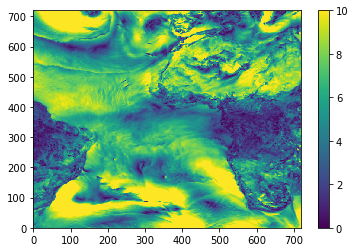

In [29]:
fudge_factor = 8  # <-- 7.5 minute time step? Confirmed by Rob.
plt.pcolormesh(mag_uava_result[0,-1,:,:]/fudge_factor, norm=plt.Normalize(0, 10))
plt.colorbar()
print((mag_uava_result[0,-1,:,:]/8).mean())

nan


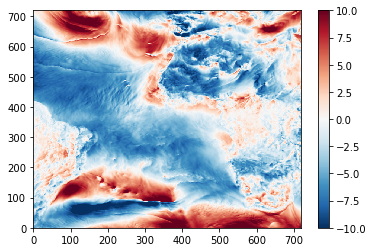

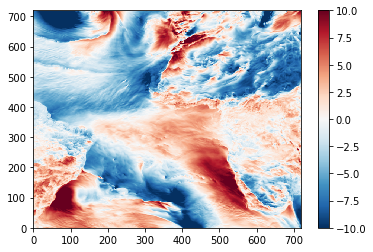

In [37]:
fudge_factor = 8
plt.figure()
plt.pcolormesh(ua_result[0,-1,:,:]/fudge_factor, norm=plt.Normalize(-10, 10), cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.pcolormesh(va_result[0,-1,:,:]/fudge_factor, norm=plt.Normalize(-10, 10), cmap='RdBu_r')
plt.colorbar()
print((ua_result[0,-1,:,:]/8).mean())

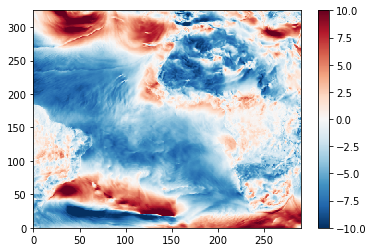

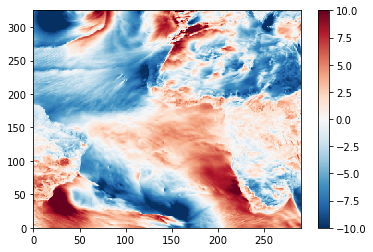

In [38]:
plt.figure()
plt.pcolormesh(ua[0,-1,200:525,400:690], norm=plt.Normalize(-10, 10), cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.pcolormesh(va[0,-1,200:525,400:690], norm=plt.Normalize(-10, 10), cmap='RdBu_r')
plt.colorbar()


In [3]:
import mf2w

In [4]:
calc_uc, calc_vc = mf2w.mass_fluxes_to_winds(tavg_1hr_ctm, c720_grid, True)

NameError: name 'c720_grid' is not defined